<a href="https://colab.research.google.com/github/Bider12/FakeNews/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jruvika/fake-news-detection

  0% 0.00/4.89M [00:00<?, ?B/s]
100% 4.89M/4.89M [00:00<00:00, 78.7MB/s]


In [4]:
!unzip fake-news-detection.zip

Archive:  fake-news-detection.zip
  inflating: data.csv                
  inflating: data.h5                 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

from itertools import chain
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import gensim

In [21]:
data = pd.read_csv("data.csv")

In [22]:
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [23]:
data.isnull().sum()

URLs         0
Headline     0
Body        21
Label        0
dtype: int64

In [24]:
data.shape

(4009, 4)

In [ ]:
# 21/4009 = 0.5% missing data, we can delete

In [25]:
data.dropna()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1
...,...,...,...,...
4003,http://beforeitsnews.com/u-s-politics/2017/10/...,CNN and Globalist Exposed - Steve Quayle and A...,"Vietnam Is in Great Danger, You Must Publish a...",0
4004,http://beforeitsnews.com/sports/2017/09/trends...,Trends to Watch,Trends to Watch\n% of readers think this story...,0
4005,http://beforeitsnews.com/u-s-politics/2017/10/...,Trump Jr. Is Soon To Give A 30-Minute Speech F...,Trump Jr. Is Soon To Give A 30-Minute Speech F...,0
4007,https://www.reuters.com/article/us-china-pharm...,China to accept overseas trial data in bid to ...,SHANGHAI (Reuters) - China said it plans to ac...,1


In [26]:
data['website'] = data.URLs.apply(lambda x: x.split('/')[2])
data.pivot_table(index = 'website', columns = 'Label', values = 'URLs', aggfunc='count').fillna(0).astype(int)

Label,0,1
website,,
abcnews.go.com,0,57
api.content-ad.net,2,0
beforeitsnews.com,1694,0
bleacherreport.com,0,8
clarivate.com,0,3
cnn.it,0,1
dailybuzzlive.com,99,0
edition.cnn.com,0,16
inhealth.cnn.com,0,14


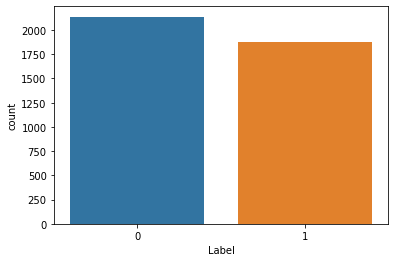

In [27]:
ax = sns.countplot(x="Label", data=data)

In [28]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

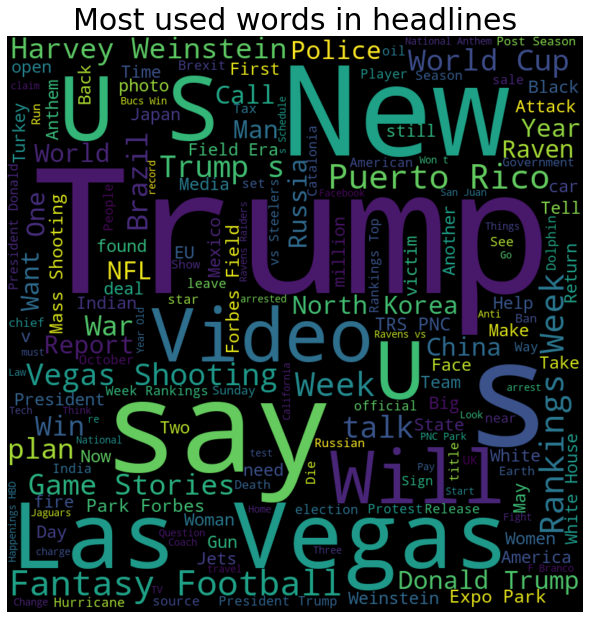

In [29]:
wordCloud_generator(data['Headline'], title="Most used words in headlines")

In [30]:
data['text'] = data['Headline'] + " " + data['Body']
data = data.drop(columns = ['Headline', 'Body','URLs'])

In [31]:
data.head()

,Label,website,text
0,1,www.bbc.com,Four ways Bob Corker skewered Donald Trump Ima...
1,1,www.reuters.com,Linklater's war veteran comedy speaks to moder...
2,1,www.nytimes.com,Trump’s Fight With Corker Jeopardizes His Legi...
3,1,www.reuters.com,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,1,www.cnn.com,Jason Aldean opens 'SNL' with Vegas tribute Co...


In [32]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [33]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [34]:
data['text'][1]

'Linklater\'s war veteran comedy speaks to modern America, says star LONDON (Reuters) - “Last Flag Flying”, a comedy-drama about Vietnam war veterans, will resonate with Trump’s America, despite, or perhaps because of, its period setting, actor Bryan Cranston said on Sunday after a screening at the London Film Festival.\nSet in the United States in December 2003 – when U.S. forces in Iraq were dragging Saddam Hussein out of a “spider hole” - it is the story of three ageing former servicemen who reunite to bury the son of one of them who has been killed in action.\nWith President Donald Trump saying he could “totally destroy” North Korea and characterizing a dinner with military commanders as “the calm before the storm”, Cranston said “Last Flag Flying” was a timely reminder of the effect on normal Americans of ill-advised military campaigns.\n“I think it has a lot of relevance today in the sense that (today) it’s not clear cut as far as the (what are the) intentions of the government o

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
#Deleting stopwords, words lower, remove punctation

In [43]:
data['text'] = data['text'].apply(lambda x: ' '.join([item for item in str(x).split() if not item in stop_words]))

In [38]:
data['text'] = data['text'].apply(lambda x: x.lower())

In [39]:
data['text'] = data['text'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [40]:
data['text'][1]

'linklaters war veteran comedy speaks modern america says star london reuters  last flag flying comedydrama vietnam war veterans resonate trumps america despite perhaps of period setting actor bryan cranston said sunday screening london film festival set united states december 2003  us forces iraq dragging saddam hussein spider hole  story three ageing former servicemen reunite bury son one killed action with president donald trump saying could totally destroy north korea characterizing dinner military commanders the calm storm cranston said last flag flying timely reminder effect normal americans illadvised military campaigns i think lot relevance today sense today its clear cut far what the intentions government military cranston acclaimed lead role tv drama breaking bad told reuters in world war two good war clear present danger stop mad man since then vietnam iraq there are lot questions  among troops citizens right thing purpose there cast member bryan cranston r director richard 

In [41]:
from gensim.models import Word2Vec as w2v

In [54]:
common_top10 = pd.Series(' '.join(data['text']).split()).value_counts()[:10]
print(common_top10)

said      9522
us        4581
one       4409
new       4237
would     4035
also      3408
two       3129
first     3024
like      2914
people    2802
dtype: int64


In [55]:
text_train, text_test, y_train, y_test = train_test_split(data['text'], data['Label'], test_size = 0.2, random_state = 42)

In [56]:
print('Train Data Size：', len(text_train))
print('Train Data Size：', len(y_train))
print('Test Data Size：', len(text_test))
print('Test Data Size：', len(y_test))

Train Data Size： 3207
Train Data Size： 3207
Test Data Size： 802
Test Data Size： 802


In [57]:
size_embedding = 256 
windows = 2 
min_count = 1 
maxlen = 1000 

text_train_splited = [article.split() for article in text_train]
w2v_model = gensim.models.Word2Vec(sentences = text_train_splited, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train_splited)
text_train_tok = tokenizer.texts_to_sequences(text_train_splited)
word_index = tokenizer.word_index
print('Size of vocabulary: ', len(word_index))

text_train_tok_pad = pad_sequences(text_train_tok, maxlen=maxlen)

Size of vocabulary:  51123


In [58]:
def w2v_to_keras_weights(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, size_embedding))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

embedding_vectors = w2v_to_keras_weights(w2v_model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [59]:
model = Sequential()
model.add(Embedding(embedding_vectors.shape[0], 
                    output_dim=embedding_vectors.shape[1],
                    weights=[embedding_vectors], 
                    input_length=maxlen, 
                    trainable=False))
model.add(LSTM(units=32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [60]:
model.summary()

history = model.fit(text_train_tok_pad, y_train, validation_split=0.2, epochs=30, batch_size = 32, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 256)         13087744  
                                                                 
 lstm (LSTM)                 (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,124,769
Trainable params: 37,025
Non-trainable params: 13,087,744
_________________________________________________________________
Epoch 1/30
81/81 [==============================] - 44s 508ms/step - loss: 0.4059 - acc: 0.8265 - val_loss: 0.3170 - val_acc: 0.8692
Epoch 2/30
81/81 [==============================] - 40s 497ms/step - loss: 0.2415 - acc: 0.9072 - val_loss: 0.2101 - val_acc: 0.9315
Epoch 3/30
81/81 [===================

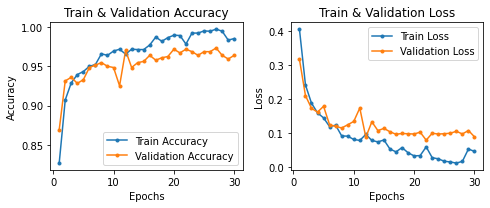

In [61]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['acc']) + 1,1)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
    
plot_loss_epochs(history)

In [62]:
model.fit(text_train_tok_pad, y_train, epochs=15, batch_size = 16, verbose = 0)

              precision    recall  f1-score   support

        Fake       0.98      0.95      0.97       455
    Not Fake       0.94      0.97      0.96       347

    accuracy                           0.96       802
   macro avg       0.96      0.96      0.96       802
weighted avg       0.96      0.96      0.96       802



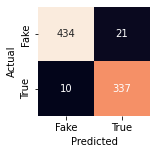

In [ ]:
text_train_splited = [article.split() for article in text_test]
text_test_tok = tokenizer.texts_to_sequences(text_train_splited)
text_test_tok_pad = pad_sequences(text_test_tok, maxlen=maxlen)
pred = (model.predict(text_test_tok_pad) > 0.5).astype("int32")

print(classification_report(y_test, pred, target_names = ['Fake','Not Fake'])) 
cm = pd.DataFrame(confusion_matrix(y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()